# Objetivos:

1. [Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable](#Objetivo-1)

2. [Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones . Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.](#Objetivo-2)

3. [Interpreta los coeficientes y su significancia estadística del modelo calibrado](#Objetivo-3)

4.  [Realiza una predicción de la variable utilizando el modelo calibrado.](#Objetivo-4)

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [87]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsap
import statsmodels.tsa.arima.model as tsa_arima
import statsmodels.api as sm

In [88]:
df = pd.read_csv('./data/IGAE.csv')

In [89]:
df.isnull().values.any()

False

Reducimos el dataset a las variables de nuestro interes

In [90]:
df = df[['Periodo', 'Valor']]
df

,Periodo,Valor
0,2022/07,111.274552
1,2022/06,112.797501
2,2022/05,114.442424
3,2022/04,109.529866
4,2022/03,111.940152
...,...,...
350,1993/05,63.612900
351,1993/04,61.865984
352,1993/03,63.943249
353,1993/02,61.022521


Comprobamos el formato de los datos

In [91]:
df.dtypes

Periodo     object
Valor      float64
dtype: object

Configuramos el periodo en un formato de fecha para poder utilizarlo

In [92]:
df['Periodo'] = pd.to_datetime(df['Periodo'], infer_datetime_format = True)

Comprobamos el formato de los datos

In [93]:
df.dtypes

Periodo    datetime64[ns]
Valor             float64
dtype: object

In [94]:
df = df.sort_values(by=['Periodo'])
df

,Periodo,Valor
354,1993-01-01,60.407691
353,1993-02-01,61.022521
352,1993-03-01,63.943249
351,1993-04-01,61.865984
350,1993-05-01,63.612900
...,...,...
4,2022-03-01,111.940152
3,2022-04-01,109.529866
2,2022-05-01,114.442424
1,2022-06-01,112.797501


## Objetivo 1
### Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable

#### Indentificacion de estacionalidad

Primeramente obsevaremos el comportamiento de la serie

<AxesSubplot:xlabel='Periodo'>

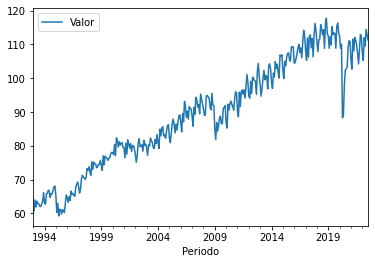

In [95]:
df.plot(x = 'Periodo', y = 'Valor')

Si bien al incio y al final de la serie podemos observar un comportamiento que pareciaera estacionario, la serie en su totalidad nos muestra un comportamiento con una tendencia creciente, y presencia de un patron estacionario.

#### Prueba de estacionalidad

In [96]:
def getStationary(df):
    stationary = df[['Periodo']]
    stationary['Seasonal difference log'] = np.log(df['Valor']).diff(12)
    stationary = stationary.dropna()
    return stationary

In [97]:
stationary = getStationary(df)
stationary

,Periodo,Seasonal difference log
342,1994-01-01,0.042483
341,1994-02-01,0.027647
340,1994-03-01,0.028476
339,1994-04-01,0.063042
338,1994-05-01,0.049767
...,...,...
4,2022-03-01,0.003661
3,2022-04-01,0.013414
2,2022-05-01,0.021001
1,2022-06-01,0.014522


<AxesSubplot:xlabel='Periodo'>

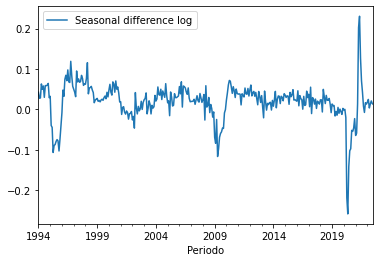

In [98]:
stationary.plot(x = 'Periodo', y = 'Seasonal difference log')

Resulta muy dificil determinar si es estacionaria unicamente observando la grafica

##### Prueba de Dicky-Fuller

Por defecto la prueba de Dicky-Fuller de statsmodels utiliza un lag de 12.

In [99]:
adfuller(stationary['Seasonal difference log'])[1]

0.0032602635688594645

Obtenemos que el p-value es de 0.003, con lo que cumple con la condicion de ser menor a 0.05, por lo que podemos afirmar que estacionaria, y podemos continuar con la calibracion del modelo

## Objetivo 2
### Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones . Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.

#### ACF

Los Metodos de ACF Y PACF regresan las correlaciones desde un lag 0 a n, por lo que se puede observar que en las primeras barrar la ausencia del horizonte.

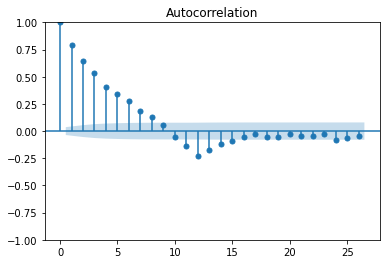

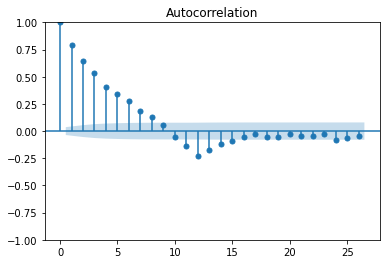

In [100]:
tsap.plot_acf(stationary['Seasonal difference log'], alpha = 0.5)

Podemos observar que los primeros 8 LAGs son positivos y significativos, decayendo de forma gradual. Lo cual nos indica que esta fuertemente correlacionado con sigo mismo del mes anterior hasta 8 meses previos (LAG 1-8).

#### PACF

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


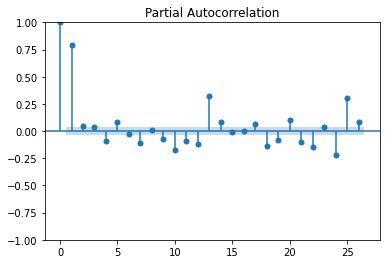

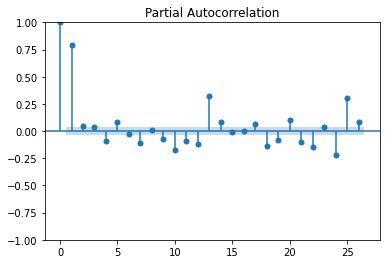

In [101]:
tsap.plot_pacf(stationary['Seasonal difference log'], alpha = 0.5)

Se puede observar que unicamente la primera autocorrelacion es positiva y significante y posteriormente decae.

#### Conclusiones

En base al analisis del ACF y PACF podemos concluir que estamos en presencia de un patron de un modelo AR(p), donde el numero de terminos esta determinado por los retrasos significativos de PACF. Por lo tanto partiremos de un modelo ARIMA con p=1 y q=0.

## Objetivo 3
### Interpreta los coeficientes y su significancia estadística del modelo calibrado

In [102]:
stationary = stationary.set_index('Periodo')

In [103]:
stationary

,Seasonal difference log
Periodo,
1994-01-01,0.042483
1994-02-01,0.027647
1994-03-01,0.028476
1994-04-01,0.063042
1994-05-01,0.049767
...,...
2022-03-01,0.003661
2022-04-01,0.013414
2022-05-01,0.021001


In [104]:
# Variables de arima
p = 1
d = 0
q = 0

# Variables de sarima
P = 0
D = 1
Q = 0
periodos = 12

Estamos modelando el % de crecimiento anual sin considerar la primera diferencia de la serie, usando el perimer terminopara AR

In [105]:
model = sm.tsa.statespace.SARIMAX(stationary['Seasonal difference log'], order = (p,d,q), seasonal_order = (P,D,Q,periodos), simple_differencing = True).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65764D+00    |proj g|=  6.89064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      6      1     0     0   4.096D-03  -1.658D+00
  F =  -1.6576464369319976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [106]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:       DS12.Seasonal difference log   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 548.681
Date:                            Mon, 24 Oct 2022   AIC                          -1093.362
Time:                                    23:46:11   BIC                          -1085.758
Sample:                                01-01-1995   HQIC                         -1090.329
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7718      0.021     36.900      0.000       0.731       0.813
sigma2         0.0021   5.36e-05     39.601      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4476.20
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

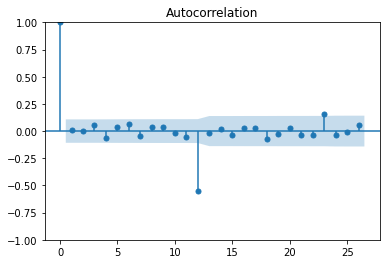

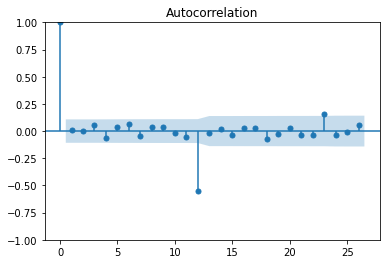

In [107]:
tsap.plot_acf(model.resid)

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


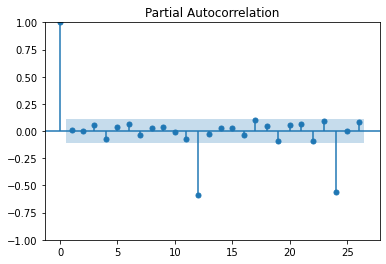

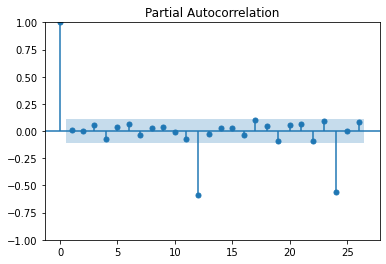

In [108]:
tsap.plot_pacf(model.resid)

El modelo no presenta ruido blanco por lo que tengo que agregar MA

In [109]:
# Variables de arima
p = 1
d = 0
q = 0

# Variables de sarima
P = 1
D = 1
Q = 3
periodos = 12

model = sm.tsa.statespace.SARIMAX(stationary['Seasonal difference log'], order = (p,d,q), seasonal_order = (P,D,Q,periodos), simple_differencing = True).fit()

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82000D+00    |proj g|=  7.49536D+00

At iterate    5    f= -1.85984D+00    |proj g|=  3.12233D-01

At iterate   10    f= -1.96959D+00    |proj g|=  2.36263D+01

At iterate   15    f= -2.11511D+00    |proj g|=  1.92422D-01

At iterate   20    f= -2.20921D+00    |proj g|=  1.81584D+00

At iterate   25    f= -2.22848D+00    |proj g|=  2.44266D-01

At iterate   30    f= -2.22992D+00    |proj g|=  1.08170D-01

At iterate   35    f= -2.23770D+00    |proj g|=  2.44664D+00

At iterate   40    f= -2.23868D+00    |proj g|=  2.91606D-03

At iterate   45    f= -2.24997D+00    |proj g|=  8.99219D-01


/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.25022D+00    |proj g|=  7.50767D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   7.508D-02  -2.250D+00
  F =  -2.2502204160425214     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [110]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:               DS12.Seasonal difference log   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2, 3], 12)   Log Likelihood                 744.823
Date:                                    Mon, 24 Oct 2022   AIC                          -1477.646
Time:                                            23:46:17   BIC                          -1454.833
Sample:                                        01-01-1995   HQIC                         -1468.547
                                             - 07-01-2022                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8776      0.020     44.842      0.000       0.839       0.916
ar.S.L12      -0.8654      0.108     -8.018      0.000      -1.077      -0.654
ma.S.L12      -0.8138      0.165     -4.925      0.000      -1.138      -0.490
ma.S.L24      -0.9256      0.267     -3.461      0.001      -1.450      -0.401
ma.S.L36       0.8099      0.124      6.522      0.000       0.567       1.053
sigma2         0.0005   5.53e-05      9.441      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   4.36   Jarque-Bera (JB):              3437.35
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

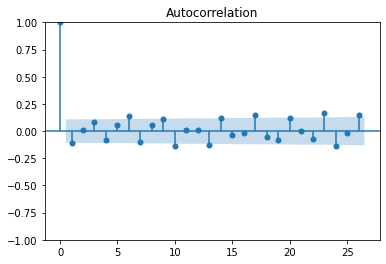

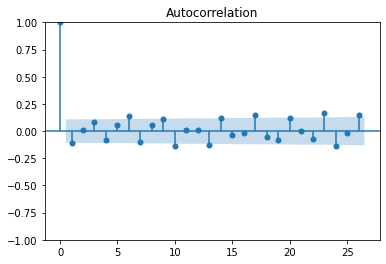

In [111]:
tsap.plot_acf(model.resid)

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


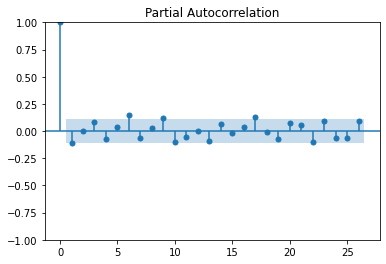

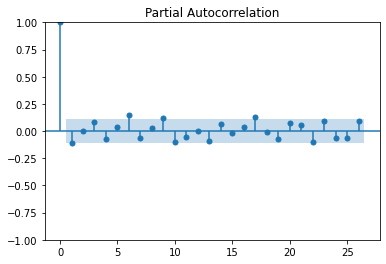

In [112]:
tsap.plot_pacf(model.resid)

In [113]:
sm.stats.acorr_ljungbox(model.resid, lags = [12])

,lb_stat,lb_pvalue
12,31.407102,0.001707


Hemos creado un modelo que estima el porcentaje de crecimiento anual (mes a mes) de la economia de Mexico

## Objetivo 4
### Realiza una predicción de la variable utilizando el modelo calibrado.

In [114]:
stationary.tail()

,Seasonal difference log
Periodo,
2022-03-01,0.003661
2022-04-01,0.013414
2022-05-01,0.021001
2022-06-01,0.014522
2022-07-01,0.012631


In [115]:
from pandas.tseries.offsets import DateOffset
future=[stationary.index[-1]+ DateOffset(months=x)for x in range(0,25)]

In [116]:
future=pd.DataFrame(index=future[1:],columns=stationary.columns)

In [117]:
stationary=pd.concat([stationary, future])
stationary.tail()

,Seasonal difference log
2024-03-01,NaN
2024-04-01,NaN
2024-05-01,NaN
2024-06-01,NaN
2024-07-01,NaN


In [118]:
stationary['forecast'] = model.predict(start = pd.to_datetime('2020-01-01'), end = pd.to_datetime('2024-07-01'), dynamic = False)


In [119]:
stationary.tail()

,Seasonal difference log,forecast
2024-03-01,NaN,-0.018501
2024-04-01,NaN,0.034156
2024-05-01,NaN,0.053584
2024-06-01,NaN,0.007047
2024-07-01,NaN,-0.016343


<AxesSubplot:>

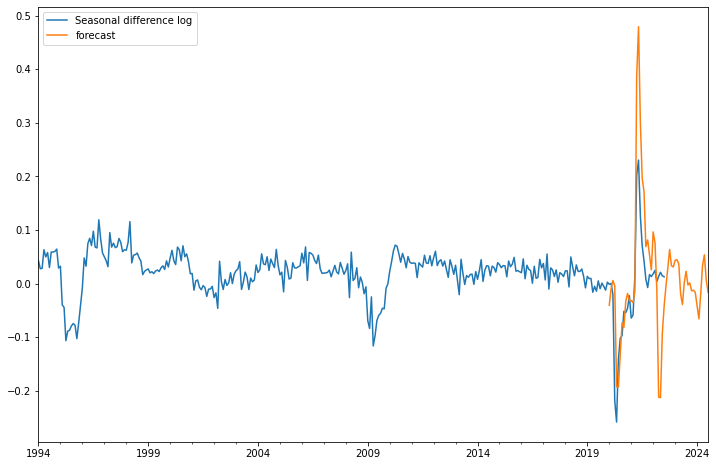

In [120]:
stationary[['Seasonal difference log', 'forecast']].plot(figsize=(12,8))

Como resultado final obtenemos una prediccion de los ultimos 37 meses previos, y de los proximos 24 meses. 

Apartir de la predicion hacia el pasado podemos observar que se comporta bastante apegado a la realidad la mayoria de tiempo, exceptuando los picos, en donde el primero lo subestimo un poco, mientras que el segundo lo sobrestimo considerablemente, ademas de predecir una bajada significatiba que en la realidad no sucedio. Por lo que no considero que sea el mejor modelo para predecir, pero que sin embargo es util para dar una idea del comportamiento general.

Analisando la prediciones a futuro, podemos decir que son diferentes al comportamiento durante la epoca de COVID, como a su vez del resto del dataset, sin embargo su comportamiento se asemeja mucho mas a la epoca previa de COVID, y en mi opinion teniendo un parecido con el perido de al rededor del 2000 